<a href="https://colab.research.google.com/github/kelvinsima2/Environmental_Audio_Classification/blob/main/Environmental_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/content/drive/My Drive/Environmental Project/Audio/44100/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [3]:
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Converting Mel Spectograms Into Images

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
import os, random, librosa
from tqdm.auto import tqdm
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models, utils, callbacks
from keras.preprocessing.image import ImageDataGenerator
sns.set_style('darkgrid')

In [5]:
def read_and_pad_sound_wave(filepath, audio_length=(44100*5)):
    waveform, sr = sf.read(filepath)
    zero_padding = np.zeros([audio_length - len(waveform)])
    waveform = np.concatenate([waveform, zero_padding], 0)
    return waveform, sr

def sound_wave_to_mel_spectrogram(sound_wave, sample_rate, spec_h=128, spec_w=128, length=1):
    NUM_MELS = spec_h
    HOP_LENGTH = int(sample_rate * length / (spec_w - 1)) 
    mel_spec = librosa.feature.melspectrogram(y=sound_wave, sr=sample_rate, hop_length=HOP_LENGTH, n_mels=NUM_MELS)
    mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [ ]:

# tf.get_logger().setLevel('INFO')

In [6]:
input_dir = '/content/drive/My Drive/Environmental Project/Audio/44100/'
output_dir = '/content/drive/My Drive/Environmental Project/Output/'

In [7]:
parent_list = os.listdir(input_dir)
for i in range(10):
    print(parent_list[i])

3-152020-B-36.wav
3-152997-A-26.wav
3-154439-A-17.wav
3-154378-A-30.wav
3-152039-A-3.wav
3-151269-A-35.wav
3-154758-A-44.wav
3-151273-A-35.wav
3-151255-A-28.wav
3-152912-A-26.wav


In [8]:
SIZE = 256
BATCH_SIZE = 32
channels = 3
kernel = 4
stride = 1
pool = 2
# for filename in tqdm(os.listdir(input_dir)):
#     if "wav" in filename:
#         file_path = os.path.join(input_dir, filename)
#         target_dir = 'class_' + filename[:-4].split('-')[3]             
#         dist_dir = os.path.join(output_dir, target_dir)
#         file_dist_path = os.path.join(dist_dir, filename)
#         if not os.path.exists(file_dist_path + '.png'):
#             if not os.path.exists(dist_dir):
#                 os.mkdir(dist_dir)                
#             S_db_mel = sound_wave_to_mel_spectrogram(*read_and_pad_sound_wave(file_path))
#             fig, ax = plt.subplots(figsize=(10, 5))
#             # Plot the mel spectogram
#             img = librosa.display.specshow(S_db_mel,
#                               x_axis='time',
#                               y_axis='log',
#                               ax=ax)
#             plt.axis('off')
#             fig.savefig(f'{file_dist_path}.png', dpi=fig.dpi)
#             plt.close()

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="training",
                                             seed=0,
                                             label_mode = 'categorical');

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=output_dir,
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(SIZE, SIZE),
                                             subset="validation",
                                             seed=0,
                                             label_mode = 'categorical');

Found 2000 files belonging to 50 classes.
Using 1600 files for training.
Found 2000 files belonging to 50 classes.
Using 400 files for validation.


In [10]:
# Obtain class names from training data. It is worth noting that they are presented in alphabetical order. This is useful during model testing.
class_names = train_dataset.class_names

In [12]:
# Display shape of training set
train_dataset.element_spec

(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 50), dtype=tf.float32, name=None))

In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 11
Number of test batches: 2


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Model Development and Evaluation

In [15]:
# Use the resnet_v2 preprocessing function to rescale pixel values
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [32]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
base_model.trainable=False

# Create Tensorflow functional model
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.BatchNormalization(renorm=True)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#x = tf.keras.layers.Dense(512, activation='relu')(x)
#x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# The output layer has 90 outputs representing the number of classes in the image dataset.
outputs = tf.keras.layers.Dense(50, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [33]:
# categorical cross entropy is taken since its used as a loss function for
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
# Get model summary
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 256, 256, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 256, 256, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_473 (Ba  (None, 6, 6, 2048)       14336     
 tchNormalization)                                               
                                                           

In [35]:
# early stopping call back
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)

In [36]:
# Train model using GPU
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset,
                    callbacks = [early])

Epoch 1/10
50/50 [==============================] - 14s 157ms/step - loss: 3.7587 - accuracy: 0.0769 - val_loss: 3.2145 - val_accuracy: 0.1815
Epoch 2/10
50/50 [==============================] - 7s 132ms/step - loss: 2.6747 - accuracy: 0.2994 - val_loss: 2.3707 - val_accuracy: 0.3631
Epoch 3/10
50/50 [==============================] - 7s 134ms/step - loss: 1.8376 - accuracy: 0.5075 - val_loss: 2.0086 - val_accuracy: 0.4643
Epoch 4/10
50/50 [==============================] - 7s 128ms/step - loss: 1.3078 - accuracy: 0.6438 - val_loss: 1.8428 - val_accuracy: 0.4940
Epoch 5/10
50/50 [==============================] - 7s 134ms/step - loss: 0.9368 - accuracy: 0.7475 - val_loss: 1.8501 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 7s 131ms/step - loss: 0.6631 - accuracy: 0.8256 - val_loss: 1.6759 - val_accuracy: 0.5685
Epoch 7/10
50/50 [==============================] - 7s 136ms/step - loss: 0.4626 - accuracy: 0.8900 - val_loss: 1.6715 - val_accuracy: 0.5476
Epoch

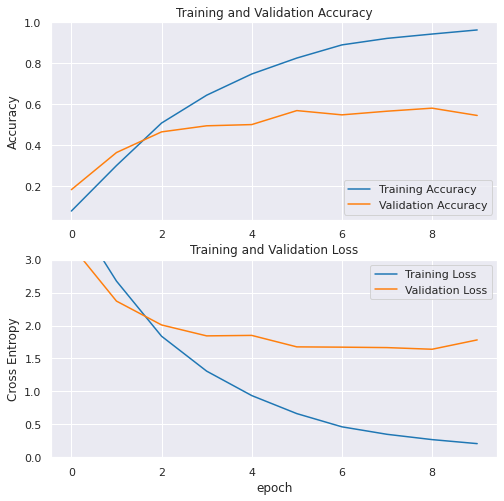

In [39]:
# Plot accuracy and loss graphs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_dataset)

2/2 [==============================] - 1s 133ms/step - loss: 1.6570 - accuracy: 0.5469


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 70

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs
with tf.device('/device:GPU:0'):
  history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
42/42 [==============================] - 12s 99ms/step - loss: -7873.9834 - accuracy: 0.0179 - val_loss: -7505.7676 - val_accuracy: 0.0111
Epoch 11/20
42/42 [==============================] - 4s 91ms/step - loss: -7929.1304 - accuracy: 0.0179 - val_loss: -8002.8379 - val_accuracy: 0.0111
Epoch 12/20
42/42 [==============================] - 4s 79ms/step - loss: -7990.0762 - accuracy: 0.0179 - val_loss: -7900.2749 - val_accuracy: 0.0111
Epoch 13/20
42/42 [==============================] - 4s 78ms/step - loss: -8047.4883 - accuracy: 0.0179 - val_loss: -7742.1743 - val_accuracy: 0.0074
Epoch 14/20
42/42 [==============================] - 5s 98ms/step - loss: -8101.7373 - accuracy: 0.0179 - val_loss: -7768.0063 - val_accuracy: 0.0111
Epoch 15/20
42/42 [==============================] - 4s 80ms/step - loss: -8160.9756 - accuracy: 0.0179 - val_loss: -8066.9961 - val_accuracy: 0.0111
Epoch 16/20
42/42 [==============================] - 4s 79ms/step - loss: -8241.6709 - accuracy: 0.